In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
from keras.preprocessing import sequence
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from tensorflow.keras.utils import pad_sequences
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
#import yfinance as yf
from datetime import timedelta
import random 
import csv
import gc
import torch
import torch.nn.functional as F
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [ ]:
!pip install yfinance

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
np.random.seed(10)
tf.random.set_seed(10)

We will use the proceesed data frame we create in the pre processing part.

In this section, we are going to turn categorical variables into dummy columns, and add new features for improve performence of the XGBoost model.

In [14]:
data = pd.read_csv('/content/drive/MyDrive/Final Project/Final data/final_data')

In [15]:
data = data.rename(columns = {'laybel':'label'})
# Create dummy variable for each quarter
dummies = pd.get_dummies(data['quarter'])
# drop na
# Add the dummies to the dataframe
data = pd.concat([data,dummies],axis =1)
data =data.rename(columns={'1':'q1','2':'q2','3':'q3','4':'q4'})
# We create stand alone df series for using later n the models
data = data.dropna(axis = 0)

Y = data['label']

In [16]:
data


Unnamed: 0  Unnamed: 0.1 symbol  quarter  year                 date  \
1               1             1    MMM        3  2010  2010-10-28 17:00:00   
2               2             2    MMM        2  2010  2010-07-22 17:00:00   
3               3             3    MMM        1  2010  2010-04-28 17:00:00   
5               5             1    ABT        1  2010  2010-04-21 17:00:00   
6               6             0    ACN        3  2010  2010-06-25 17:00:00   
...           ...           ...    ...      ...   ...                  ...   
22523       22523             2   ZION        2  2022  2022-07-26 20:34:03   
22524       22524             3   ZION        1  2022  2022-04-25 22:39:06   
22526       22526             1    ZTS        3  2022  2022-11-03 11:17:09   
22527       22527             2    ZTS        2  2022  2022-08-04 13:25:02   
22528       22528             3    ZTS        1  2022  2022-05-05 13:50:08   

                                                 content        Date  \
1      Operator: Ladies and gentlemen, thank you for ...  2010-10-28   
2      Operator: Ladies and gentlemen, thank you for ...  2010-07-22   
3      Operator: [ABRUPT START] As a reminder, this c...  2010-04-28   
5      Operator: Good morning and thank you for stand...  2010-04-21   
6      Operator: Ladies and gentlemen, thank you for ...  2010-06-25   
...                                                  ...         ...   
22523  Operator: Greetings, welcome to the Zions Banc...  2022-07-26   
22524  Operator: Greetings. Welcome to the Zions Banc...  2022-04-25   
22526  Operator: Welcome to the Third Quarter 2022 Fi...  2022-11-03   
22527  Operator: Welcome to the Second Quarter 2022 F...  2022-08-04   
22528  Operator: Welcome to the First Quarter 2022 Fi...  2022-05-05   

       p_sp500_start  p_sp500_end    p_sp500  price_start  price_end  \
1        1069.589966  1182.449951  10.551706      82.3000    90.3700   
2        1183.709961  1069.589966  -9.640875      87.9700    82.3000   
3        1091.760010  1183.709961   8.422176      81.4800    87.9700   
5        1092.170044  1207.170044  10.529496      26.1394    25.4581   
6        1165.729980  1073.689941  -7.895485      41.5200    37.5500   
...              ...          ...        ...          ...        ...   
22523    4271.779785  3966.840088  -7.138469      60.7400    54.0900   
22524    4397.939941  4271.779785  -2.868619      61.7500    60.7400   
22526    4155.169922  3759.689900  -9.517782     180.1600   147.3600   
22527    4300.169922  4155.169922  -3.371960     176.8600   180.1600   
22528    4401.669922  4300.169922  -2.305943     196.4300   176.8600   

           yield  label  1  2  3  4  
1       9.805589    0.0  0  0  1  0  
2      -6.445379    1.0  0  1  0  0  
3       7.965145    0.0  1  0  0  0  
5      -2.606410    2.0  1  0  0  0  
6      -9.561657    0.0  0  0  1  0  
...          ...    ... .. .. .. ..  
22523 -10.948304    2.0  0  1  0  0  
22524  -1.635628    0.0  1  0  0  0  
22526 -18.206039    2.0  0  0  1  0  
22527   1.865883    1.0  0  1  0  0  
22528  -9.962837    2.0  1  0  0  0  

[21139 rows x 19 columns]

In [17]:
data = data.drop('Unnamed: 0' , axis='columns')
data = data.drop('Unnamed: 0.1' , axis='columns')

For each company we will add a dummy variable which is the sector that this company belong. We belive diffrent sector will have diffrent effect to the company performence.

In [20]:
import yfinance as yf

# Download S&P 500 companies
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = sp500['Symbol'].to_list()

# Download historical data for each company
data_yf = yf.download(tickers, start='2010-01-01', end='2022-03-03')['Adj Close']


[*********************100%***********************]  502 of 502 completed

3 Failed downloads:
- GEHC: Data doesn't exist for startDate = 1262322000, endDate = 1646283600
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


 Adding the sectors for each symbol

In [21]:
df = data.copy()
df = pd.merge(data,sp500 , left_on='symbol', right_on='Symbol')
sector_dummies = pd.get_dummies(df['GICS Sector'])
df = pd.concat([df,sector_dummies],axis =1)

We will prepare 2 types of matrix for the text column.
<br>
One matrix which the text will represent as frequancy word vector and the other as TF-IDF.

In [67]:
vectorizer = CountVectorizer()
X_vectorizer_bow= vectorizer.fit_transform(df['content'])

In [68]:
vectorizer = TfidfVectorizer(max_features=300, ngram_range=(1,3), stop_words='english')
X_tfidf = vectorizer.fit_transform(df['content'])

Adding column of sentiment score

We used TextBlob that is a Python library for processing textual data that includes a built-in sentiment analysis feature which assigns polarity scores to text based on the sentiment expressed. The score is how posetive the word 

In [24]:
from textblob import TextBlob

# Define function to calculate sentiment scores
# The score is between -1 to 1 which 1 represent positive score and -1 represent negative score
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [25]:
import json

In [26]:
# This is matrix which we create that include each paragraph for each company
with open('/content/drive/MyDrive/Final Project/Data Preprocessing/Part 1/data_matrix_3D_with_no_stopwords_after_sentiment_and_united_to_para.json') as f:
    # load the contents of the file into a dictionary
    data = json.load(f)


In [27]:
# We sending each paragraph to get_sentiment function and get the score of the sentiment of the text
by_paragpraph = []
for i in range(len(data)):
  l = []
  for j in range(len(data[i])):
    l.append(get_sentiment(data[i][j]))
  by_paragpraph.append(l)


In [28]:
# We calculate the mean sentiment score of the all pargraph of each text for getting the text sentiment score
np.mean(by_paragpraph)

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


array([ 1.37412456e-05,  1.63958044e-05, -3.54794456e-06, ...,
        1.61270207e-05,  1.32343964e-05,  1.70301339e-05])

In [29]:
# We create a new column call sentiment 
df['sentiment'] = df['content'].apply(get_sentiment)

In [30]:
df.head()

symbol  quarter  year                 date  \
0    MMM        3  2010  2010-10-28 17:00:00   
1    MMM        2  2010  2010-07-22 17:00:00   
2    MMM        1  2010  2010-04-28 17:00:00   
3    MMM        4  2011  2012-01-26 17:00:00   
4    MMM        3  2011  2011-10-25 17:00:00   

                                             content        Date  \
0  Operator: Ladies and gentlemen, thank you for ...  2010-10-28   
1  Operator: Ladies and gentlemen, thank you for ...  2010-07-22   
2  Operator: [ABRUPT START] As a reminder, this c...  2010-04-28   
3  Operator: Ladies and gentlemen, thank you for ...  2012-01-26   
4  Operator: Ladies and gentlemen, thank you for ...  2011-10-25   

   p_sp500_start  p_sp500_end    p_sp500  price_start  ...  Consumer Staples  \
0    1069.589966  1182.449951  10.551706        82.30  ...                 0   
1    1183.709961  1069.589966  -9.640875        87.97  ...                 0   
2    1091.760010  1183.709961   8.422176        81.48  ...                 0   
3    1290.839966  1326.060059   2.728463        90.32  ...                 0   
4    1337.430054  1254.189941  -6.223885        95.07  ...                 0   

   Energy  Financials  Health Care  Industrials  Information Technology  \
0       0           0            0            1                       0   
1       0           0            0            1                       0   
2       0           0            0            1                       0   
3       0           0            0            1                       0   
4       0           0            0            1                       0   

   Materials Real Estate Utilities sentiment  
0          0           0         0  0.152048  
1          0           0         0  0.164649  
2          0           0         0  0.176883  
3          0           0         0  0.170631  
4          0           0         0  0.143004  

[5 rows x 37 columns]

In [39]:

nltk.download('opinion_lexicon')
positive_words = set(nltk.corpus.opinion_lexicon.positive())
nltk.download('punkt')
# calculate the percentage of positive words in a text
# here we create a column which represent the precentage of the positive word
def calculate_positive_percentage(text):

    words = nltk.word_tokenize(text.lower())
    positive_count = sum(1 for word in words if word in positive_words)
    total_count = len(words)

    if total_count == 0:
        return 0
    else:
        return positive_count / total_count * 100

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [40]:
lst = []
for i in df['content']:
  lst.append(calculate_positive_percentage(i))

In [41]:
neg_words = set(nltk.corpus.opinion_lexicon.negative())

# define a function to calculate the percentage of negative words in a text
# here we create a column which represent the precentage of the negative word

def calculate_negaitive_percentage(text):
    words = nltk.word_tokenize(text.lower())
    neg_count = sum(1 for word in words if word in neg_words)
    total_count = len(words)
    if total_count == 0:
        return 0
    else:
        return neg_count / total_count * 100

In [42]:
negative = []
for i in df['content']:
  negative.append(calculate_negaitive_percentage(i))

In [43]:
df['negative_score'] = negative

In [44]:
df['positive_score'] = lst




---
### Getting the weights for each company 






This code is for getting the weights of each company by year in the  s&p 500 list. we are going to add this as a feature


In [45]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Define function to scrape S&P 500 index data from Wikipedia
def scrape_sp500(year):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
    html = requests.get(url, headers=headers).content
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    rows = table.findAll('tr')[1:]
    companies = []
    for row in rows:
        cols = row.findAll('td')
        if len(cols) > 0:
            ticker = cols[0].text.strip()
            name = cols[1].text.strip()
            sector = cols[3].text.strip()
            companies.append((ticker, name, sector))
    sp500 = pd.DataFrame(companies, columns=['Symbol', 'Name', 'Sector'])
    sp500.to_csv('sp500_companies_{}.csv'.format(year), index=False)

# Loop through each year from 2010 until today and scrape S&P 500 data
for year in range(2010, pd.Timestamp.today().year + 1):
    scrape_sp500(year)


In [46]:
    # Get S&P 500 index data for each year from 2010 until today
start_date = '2010-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [47]:
import yfinance as yf
import pandas as pd
#  This function calculate the weigh of each company in the S&P 500
def calculate_sp500_weight(tickers):
    sp500 = yf.Ticker('^GSPC')
    sp500_history = sp500.history(start="2010-01-01")
    years = sp500_history.index.year.unique()

    company_weights = []
    for ticker in tickers:
        company = yf.Ticker(ticker)
        company_history = company.history(start="2010-01-01")
        for year in years:
            year_start = str(year) + '-01-01'
            year_end = str(year) + '-12-31'
            year_market_cap = company_history.loc[year_start:year_end]['Close'] * company_history.loc[year_start:year_end]['Volume']
            sp500_year_market_cap = sp500_history.loc[year_start:year_end]['Close'] * sp500_history.loc[year_start:year_end]['Volume']
            weight = year_market_cap.sum() / sp500_year_market_cap.sum()
            company_weights.append({'Ticker': ticker, 'Year': year, 'Weight': weight})

    df = pd.DataFrame(company_weights)
    df = df.pivot(index='Ticker', columns='Year', values='Weight')
    return df



In [48]:
tk = calculate_sp500_weight(tickers)

Got error from yahoo api for ticker BRK.B, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BRK.B: No timezone found, symbol may be delisted
BF.B: No data found for this date range, symbol may be delisted


In [49]:
df['weight'] = 0 

In [50]:
for i in df['symbol']:
  for j in range(2010,2024):
    df.loc[(df['symbol']==i)&(df['year']==j),'weight'] = tk.loc[i,j]



In [51]:
df.head()

symbol  quarter  year                 date  \
0    MMM        3  2010  2010-10-28 17:00:00   
1    MMM        2  2010  2010-07-22 17:00:00   
2    MMM        1  2010  2010-04-28 17:00:00   
3    MMM        4  2011  2012-01-26 17:00:00   
4    MMM        3  2011  2011-10-25 17:00:00   

                                             content        Date  \
0  Operator: Ladies and gentlemen, thank you for ...  2010-10-28   
1  Operator: Ladies and gentlemen, thank you for ...  2010-07-22   
2  Operator: [ABRUPT START] As a reminder, this c...  2010-04-28   
3  Operator: Ladies and gentlemen, thank you for ...  2012-01-26   
4  Operator: Ladies and gentlemen, thank you for ...  2011-10-25   

   p_sp500_start  p_sp500_end    p_sp500  price_start  ...  Health Care  \
0    1069.589966  1182.449951  10.551706        82.30  ...            0   
1    1183.709961  1069.589966  -9.640875        87.97  ...            0   
2    1091.760010  1183.709961   8.422176        81.48  ...            0   
3    1290.839966  1326.060059   2.728463        90.32  ...            0   
4    1337.430054  1254.189941  -6.223885        95.07  ...            0   

   Industrials  Information Technology  Materials  Real Estate  Utilities  \
0            1                       0          0            0          0   
1            1                       0          0            0          0   
2            1                       0          0            0          0   
3            1                       0          0            0          0   
4            1                       0          0            0          0   

   sentiment negative_score positive_score    weight  
0   0.152048       0.715970       2.689252  0.000046  
1   0.164649       0.996236       2.715667  0.000046  
2   0.176883       0.908251       3.440579  0.000046  
3   0.170631       0.612967       3.030303  0.000049  
4   0.143004       0.859005       2.458531  0.000049  

[5 rows x 40 columns]

In [ ]:
X_features = df[['year',1, 3,  'Communication Services',
       'Consumer Discretionary',       'Consumer Staples',
                       'Energy',             'Financials',
                  'Health Care',            'Industrials',
       'Information Technology',              'Materials',
                  'Real Estate','Negative_score','Positive_score',
                       'weight']].values

---
### Training and preformance of Xgboost model

In [87]:
df.to_csv('/content/drive/MyDrive/Final Project/XGBoost/xgboot_final_df.csv')


In [60]:
results = {}
# This function calculate accuracy
def get_acc_by_model(x_text, name, cols=None):
    if cols is not None:
        features = df[cols].values.astype('float64')
        X_forthispart = hstack((x_text, features))
    else:
        X_forthispart = x_text
    X_train, X_test, y_train, y_test = train_test_split(X_forthispart, Y, test_size=0.2)
    xgb_model = xgb.XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=1000)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    if cols is not None:
        results[name] = [accuracy, features]
    else:
        results[name] = [accuracy, None]


We will try the XGBosst with many type of feature and see which give us the best accuracy.

In [70]:
tfidf_text = get_acc_by_model(X_tfidf,"TF-IDF model")

Accuracy: 0.41911069063386946


In [71]:
bowmodel = get_acc_by_model(X_vectorizer_bow,'BOW Model')

Accuracy: 0.4176915799432356


In [ ]:
tidf_withcols = get_acc_by_model(X_tfidf,"tfidf with cols",[ 'q2',  'q3',
                              'q4',                  'Communication Services',
       'Consumer Discretionary',       'Consumer Staples',
                       'Energy',             'Financials',
                  'Health Care',            'Industrials',
       'Information Technology',              'Materials',
                  'Real Estate',              'Utilities',
                    'sentiment',                 'weight','year'])

Accuracy: 0.40491958372753073


In [ ]:
bow_withcols = get_acc_by_model(X_vectorizer_bow,"tfidf with cols",['q2','q3',
                              'q4',                  'Communication Services',
       'Consumer Discretionary',       'Consumer Staples',
                       'Energy',             'Financials',
                  'Health Care',            'Industrials',
       'Information Technology',              'Materials',
                  'Real Estate',              'Utilities',
                    'sentiment',                 'weight','year'])

Accuracy: 0.4105960264900662


In [ ]:
#params 5,0.1,700
bow_withlesscols = get_acc_by_model(X_vectorizer_bow,'vecorizer and less cols',
                                    ['q1','q2','q3','year',
                                     'sentiment','weight'])

Accuracy: 0.41461684011352884


In [ ]:
#params 5,0.1,700
bow_withlesscols = get_acc_by_model(X_vectorizer_bow,'vecorizer ',
                                    ['q1','q2','q3',
                                     'sentiment','weight'])

Accuracy: 0.41367076631977295


In [ ]:
#params 10,0.1,1000
bow_withlesscols = get_acc_by_model(X_vectorizer_bow,'vecorizer qs w ans s',
                                    ['q1','q2','q3',
                                     'sentiment','weight'])

Accuracy: 0.4262062440870388


In [ ]:
#params 10,0.1,1000
bow_withlesscols = get_acc_by_model(X_vectorizer_bow,'vecorizer cols weigth sem',
                                    ['sentiment','weight'])

Accuracy: 0.4141438032166509


In [ ]:
#params 10,0.1,1000
model_with_prices = get_acc_by_model(X_tfidf,'tfidf with diff fetures',['sentiment','weight'])

Accuracy: 0.41367076631977295


In [86]:
#params 10,0.1,1000
model_with_positive_negative_prc = get_acc_by_model(X_vectorizer_bow,'model with percentage',['sentiment','weight','Positive_score',
                                                                                              'Negative_score','q1','q2','q3','Information Technology'])

Accuracy: 0.43117313150425735


We tried to implemnt grid search for the parameters but it's take a lot of time so we give up on this

### Some Visualization

In [ ]:
# group text by symbol across all years
grouped_text = df.groupby('symbol')['content'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
filtered_df = grouped_text[grouped_text['symbol'].isin(['AAPL','MSFT','AMZN','GOOGL','TSLA','JPM','V','BAC','JNJ','META','PG'])]


**Words Plot**<br>
Here we choose 10 big componies in th es&p 500 index and then plot the words.

In [ ]:
# group text by symbol across all years
grouped_text = df.groupby('symbol')['content'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
filtered_df = grouped_text[grouped_text['symbol'].isin(['AAPL','MSFT','AMZN','GOOGL','TSLA','JPM','V','BAC','JNJ','META','PG'])]


In [ ]:
filtered_df

symbol                                            content
3     AAPL  Operator Good day ladies gentlemen welcome App...
34    AMZN  Operator Good day welcome Amazon Quarterly Con...
53     BAC  Operator time participants listen mode. Operat...
248    JNJ  Louise Mehrotra Good morning welcome. Im Louis...
250    JPM  Operator Good morning ladies gentlemen. Welcom...
293   META  Operator Good afternoon. name Jay conference o...
312   MSFT  Operator Welcome Microsoft Third Quarter Fisca...
358     PG  Operator Good morning welcome Procter Gambles ...
439   TSLA  Operator Good day ladies gentlemen welcome Tes...
455      V  Operator Welcome Visa Inc.s Fiscal Q3 2010 Ear...

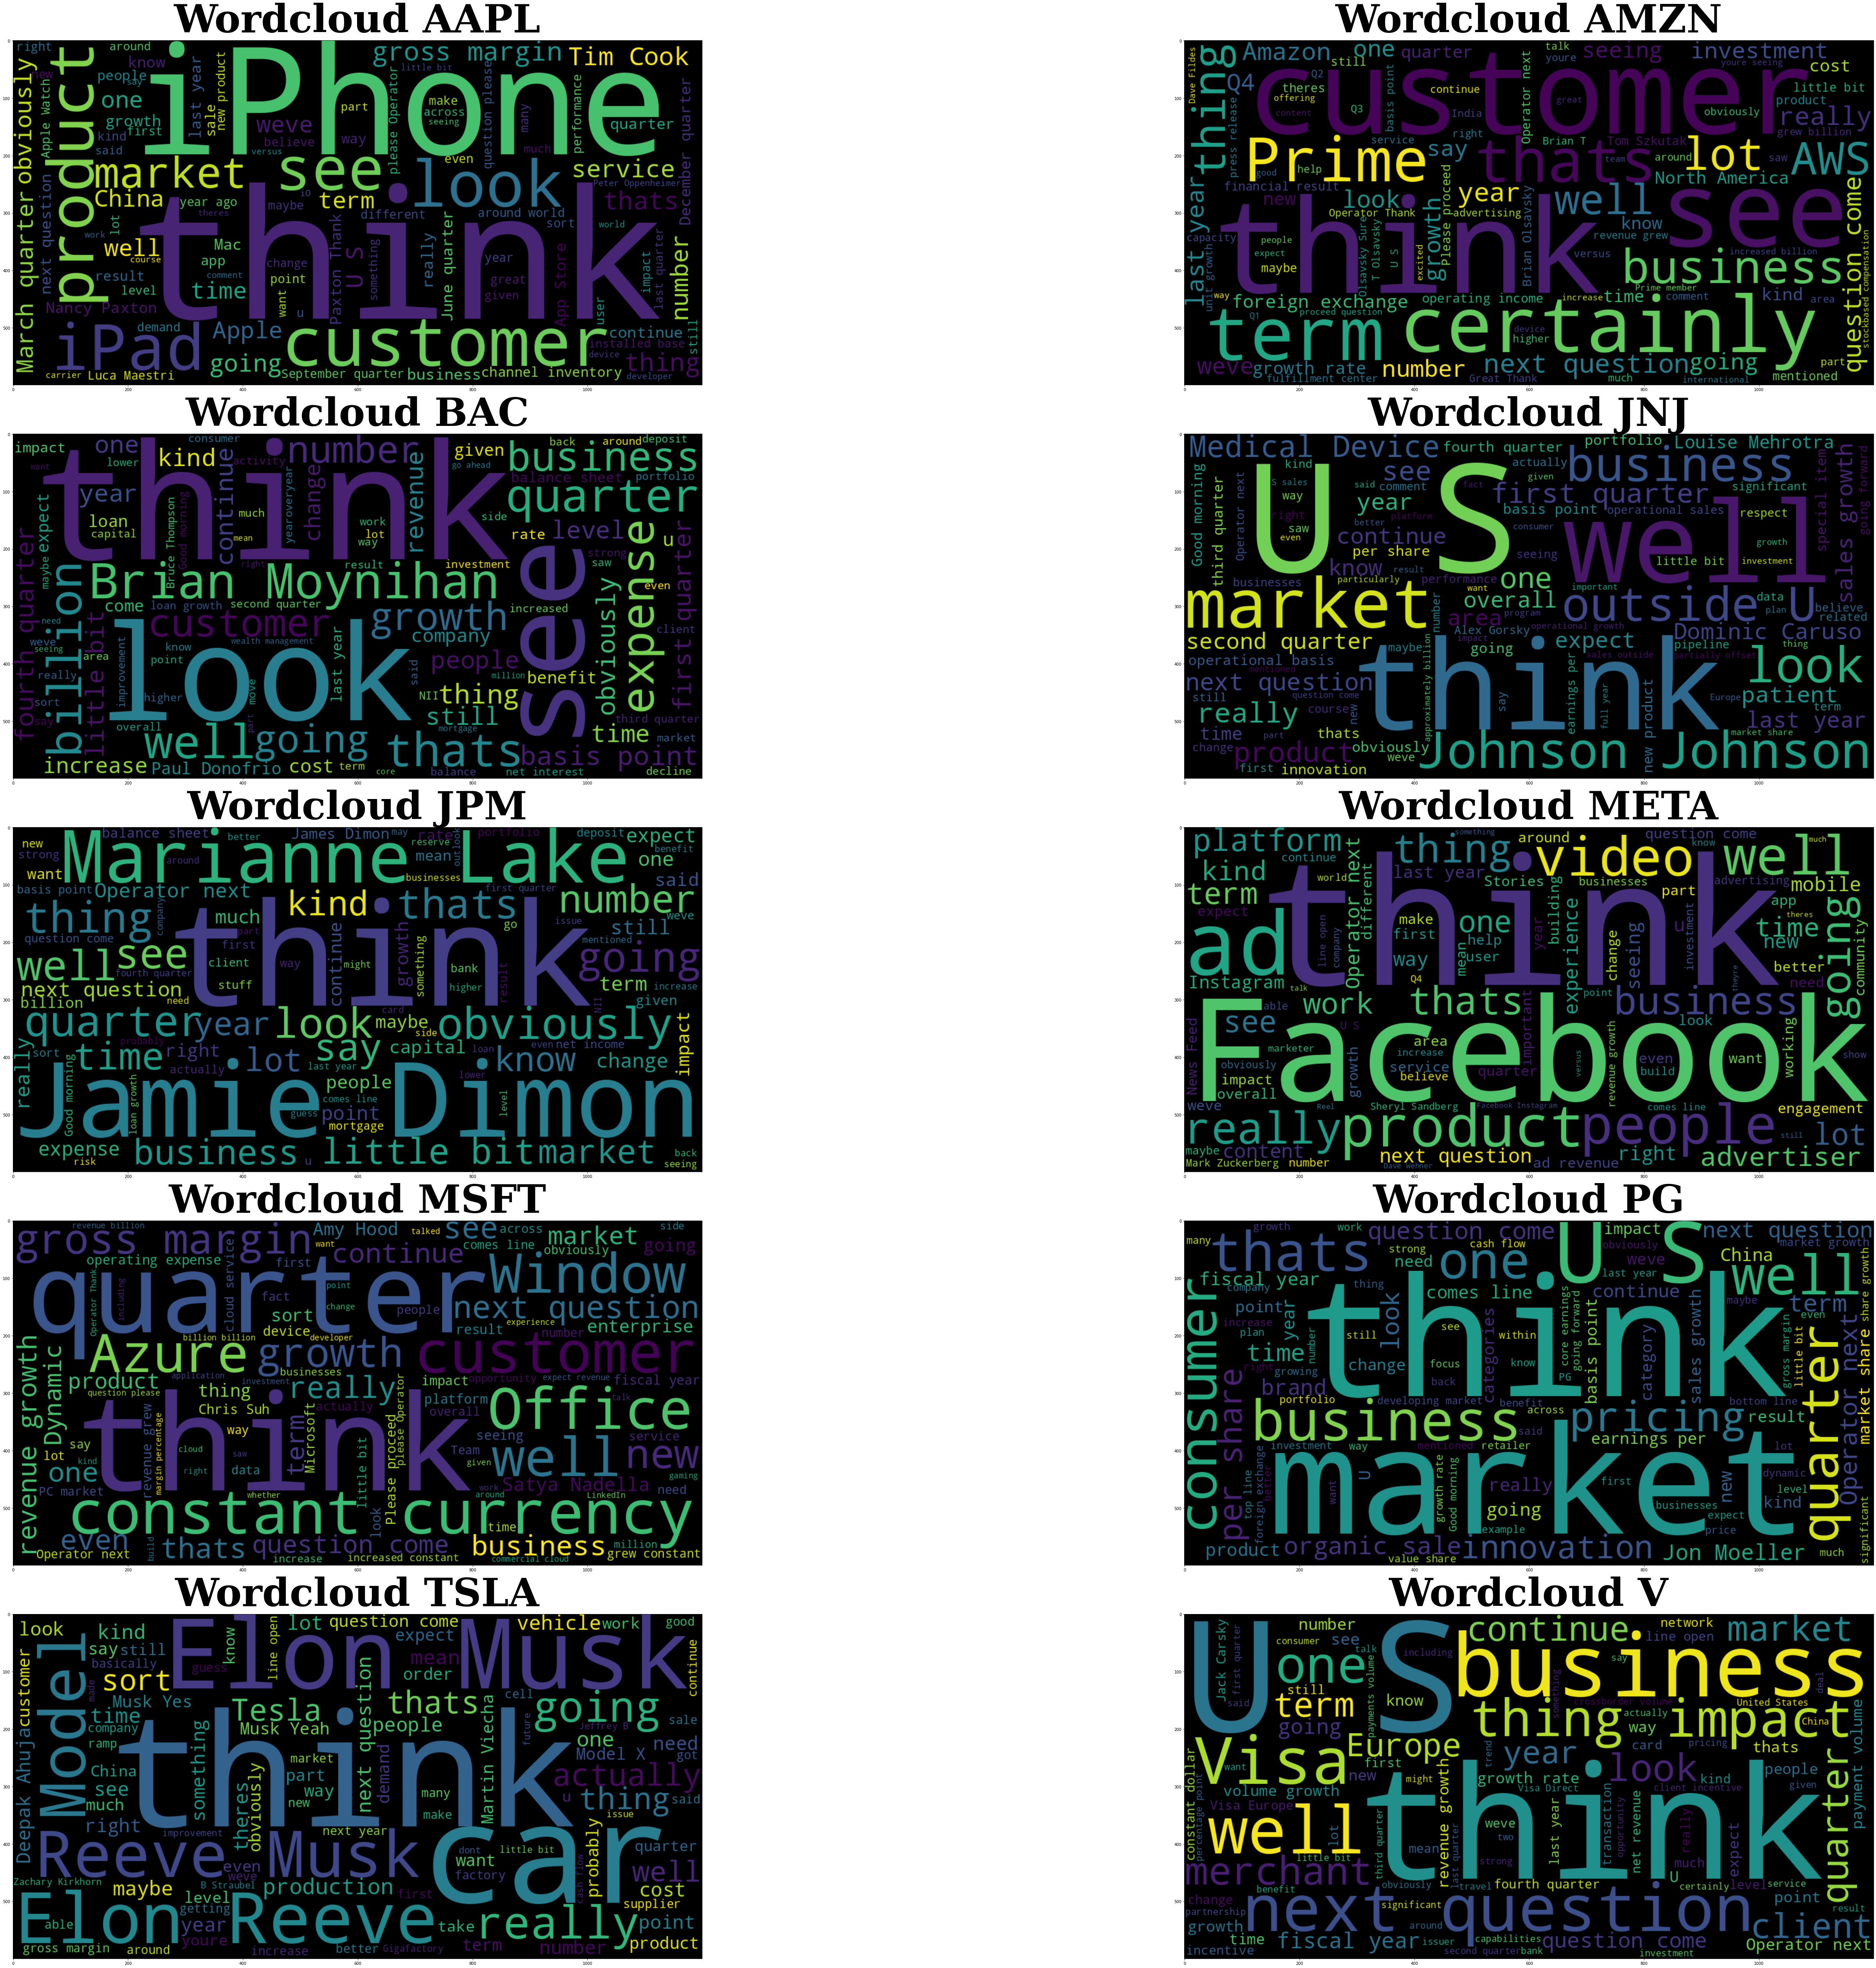

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(100,70))

for i, ax in enumerate(axes.flat):
    words = filtered_df['content'][filtered_df.index[i]]
    WC = WordCloud(width=1200, height=600, max_words=100, min_font_size=5)
    words = WC.generate(words)
    ax.imshow(words, interpolation='bilinear')
    ax.set_title('Wordcloud {}'.format(filtered_df['symbol'][filtered_df.index[i]]), fontdict={'fontsize': 100, 'family': 'serif', 'weight': 'bold'})

plt.tight_layout()
plt.show()



We can see above the most common words for the big 10 companies of the S&P 500.
For example we can see the most common words in tesla are "Elon Musk",, "vehicle" , "china"

In [ ]:
symbol_groups = df.groupby('Symbol')
fig = px.line(df, x='year', y='weight', color='Symbol', labels={'year': 'Time', 'weight': 'Weight'})
fig.update_layout(title="Weight during time")
fig.show()


We can see above the change of weights of each company. By double click of the symbol you can adjust to see the company you looking for.

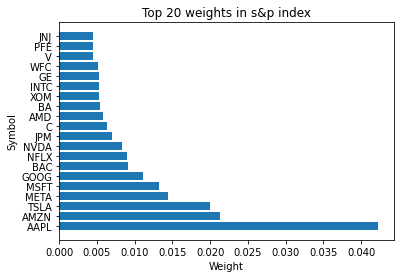

In [ ]:
symbol_weights = df.groupby('Symbol')['weight'].sum().reset_index()
top_20 = symbol_weights.sort_values('weight', ascending=False).head(20)
plt.barh(top_20['Symbol'], top_20['weight'])
plt.xlabel('Weight')
plt.ylabel('Symbol')
plt.title("Top 20 weights in s&p500 index")
plt.show()


We can see apple is the most significnt company in the S&P with weight of more than 4%